In [ ]:
mlflow ui --port 8082 --backend-store-uri sqlite:///mlruns.db

In [1]:
import os
from joblib import dump, load
from warnings import filterwarnings
from datetime import datetime

import mlflow
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import randint, uniform, loguniform

# import statsmodels.api as sm
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.arima.model import ARIMA

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.preprocessing import PowerTransformer, FunctionTransformer, OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import TransformedTargetRegressor, make_column_transformer, ColumnTransformer
from xgboost.sklearn import XGBRegressor
# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import RNN, LSTM, Conv1D

from src.data_visuals import *
from src.evaluation import *
from src.feature_engineering import *

In [2]:
filterwarnings("ignore")

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

plt.rcParams["font.size"] = 14.0
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False

mlflow.set_tracking_uri("sqlite:///mlruns.db")

SEED = 42

# Experiments

In [3]:
file_path = os.path.join("data", "energydata_complete.csv")
data = pd.read_csv(file_path)

data.date = pd.to_datetime(data.date, format="%d-%m-%Y %H:%M")
data.set_index("date", inplace=True)

data["Appliances_24"] = data.Appliances.shift(-24*6) # target variable

enhancer = DataEnhancer(data)
enhanced_data = (enhancer
                 .add_datetime_features()
                 .drop_features("RH_6")
                 .mark_high_values()
                 .add_moving_average(windows=[3, 6, 12])
                 .data)

enhanced_data.head(2)

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,Appliances_24,day_of_week,hour,minute,time_of_day,week_of_year,day_of_year,is_holiday,is_weekend,is_high_usage,mean_usage_by_hour,max_usage_by_hour,max_usage_by_hour_minute,moving_av_3,moving_av_6,moving_av_12
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 18:50:00,580,60,20.066667,46.396667,19.426667,44.4,19.79,44.826667,19.0,46.430000,17.1,55.00,6.123333,17.530000,44.263333,18.066667,48.633333,16.890000,45.29,5.98,734.433333,91.166667,5.833333,40.0,4.62,8.827838,8.827838,30.0,Monday,18,50,evening,2,11,0,0,1,190.364520,1080,1080,293.333333,176.666667,115.833333
2016-01-11 19:00:00,430,50,20.133333,48.000000,19.566667,44.4,19.89,44.900000,19.0,46.363333,17.1,55.09,6.123333,17.823333,45.493333,18.066667,48.560000,16.963333,45.29,6.00,734.500000,91.000000,6.000000,40.0,4.60,34.351142,34.351142,50.0,Monday,19,0,evening,2,11,0,0,1,143.065693,890,890,413.333333,238.333333,146.666667


In [4]:
mlflow.create_experiment(name="Initial experiments")

2024/01/17 21:24:48 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/01/17 21:24:48 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

'1'

In [5]:
mlflow.set_experiment("Initial experiments")

<Experiment: artifact_location='/home/kasia/DS/energy/Appliances_energy_prediction/mlruns/1', creation_time=1705523088899, experiment_id='1', last_update_time=1705523088899, lifecycle_stage='active', name='Initial experiments', tags={}>

In [6]:
EN, Ri, ETR, HGBR, RFR, XGBR = (ElasticNet(), Ridge(), ExtraTreesRegressor(),
                                HistGradientBoostingRegressor(), RandomForestRegressor(), 
                                XGBRegressor())

models = [model.set_params(random_state=SEED) for model in [EN, Ri, ETR, HGBR, RFR, XGBR]]

log_transformer = FunctionTransformer(func=np.log, inverse_func=np.exp)
sqrt_transformer = FunctionTransformer(func=np.sqrt, inverse_func=np.square)

target_transformations = [log_transformer, sqrt_transformer, None]

params = [{
        "regressor__model__alpha": loguniform(1e-2, 1e1),
        "regressor__model__l1_ratio": uniform(0.0, 1.0),
        "regressor__preprocessor__continuous__ct__power": [PowerTransformer(), log_transformer, "passthrough"],
        "regressor__preprocessor__continuous__pca__n_components": [0.4, 0.6, 0.8, None],
        "transformer": target_transformations
    },
    {
        "regressor__model__alpha": loguniform(1e-2, 1e1),
        "regressor__preprocessor__continuous__ct__power": [PowerTransformer(), log_transformer, "passthrough"],
        "regressor__preprocessor__continuous__pca__n_components": [0.4, 0.6, 0.8, None],
        "transformer": target_transformations
    },
    {
        "regressor__model__n_estimators": randint(100, 200),
        "regressor__model__max_depth": randint(3, 10),
        "regressor__model__min_samples_leaf": randint(5, 50),
        "regressor__preprocessor__continuous__ct__power": ["passthrough"],
        "regressor__preprocessor__continuous__pca__n_components": [0.4, 0.6, 0.8, None],
        "transformer": target_transformations
    },
    {
        "regressor__model__learning_rate": loguniform(1e-3, 1e0),
        "regressor__model__max_iter": randint(50, 100),
        "regressor__model__max_depth": randint(3, 10),
        "regressor__model__min_samples_leaf": randint(5, 50),
        "regressor__preprocessor__continuous__ct__power": ["passthrough"],
        "regressor__preprocessor__continuous__pca__n_components": [0.4, 0.6, 0.8, None],
        "transformer": target_transformations
    },
    {
        "regressor__model__n_estimators": randint(100, 200),
        "regressor__model__max_depth": randint(3, 10),
        "regressor__model__min_samples_leaf": randint(5, 50),
        "regressor__preprocessor__continuous__ct__power": ["passthrough"],
        "regressor__preprocessor__continuous__pca__n_components": [0.4, 0.6, 0.8, None],
        "transformer": target_transformations
    },
    {
        "regressor__model__n_estimators": randint(100, 200),
        "regressor__model__max_depth": randint(3, 10),
        "regressor__model__subsample": uniform(0.5, 0.5),
        "regressor__model__colsample_bytree": uniform(0.3, 0.7),
        "regressor__model__min_child_weight": randint(5, 50),
        "regressor__model__eta": loguniform(1e-3, 1e0),
        "regressor__model__gamma": loguniform(1e-4, 1e2),
        "regressor__model__alpha": loguniform(1e-4, 1e2),
        "regressor__preprocessor__continuous__ct__power": ["passthrough"],
        "regressor__preprocessor__continuous__pca__n_components": [0.4, 0.6, 0.8, None],
        "transformer": target_transformations
    }
]

In [7]:
week = 144*7
tscv = TimeSeriesSplit(n_splits=5, test_size=2*week, gap=0)

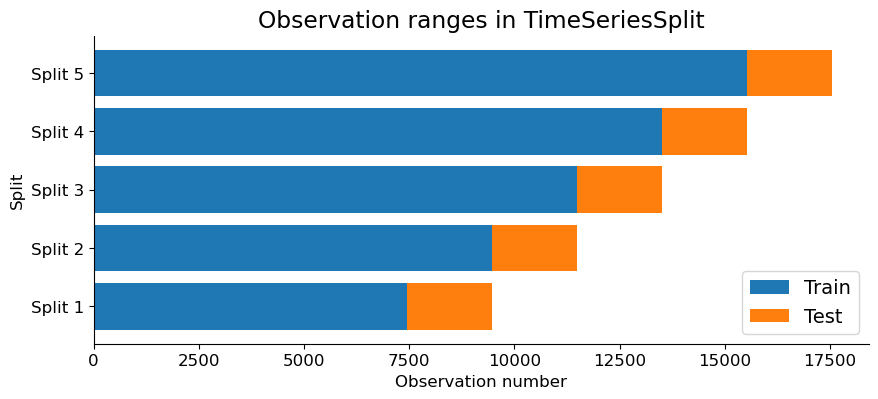

In [11]:
time_series_split(tscv, X_train)

In [8]:
number_of_lag_features = [12, 24, 48, 72, 144]

for number in number_of_lag_features:
    
    with mlflow.start_run(run_name=f"lagged_features_{number}",
                          tags={"run": "lagged_features", "level": "parent"},
                          description="different number of lagged features") as parent_run:
        
        enhanced_data = enhancer.add_lagged_features(lag=1, how_many=number, return_new=True)
        
        X = enhanced_data.drop(["Appliances", "Appliances_24"], axis = 1)
        y = enhanced_data.Appliances_24
        
        n_test = 2*week
        X_train, y_train = X.iloc[:-n_test], y.iloc[:-n_test]
        X_test, y_test = X.iloc[-n_test:], y.iloc[-n_test:]
        
        lagged_features = [feature for feature in X.columns if feature.startswith("lag")]
        num_unique_values = X.select_dtypes(exclude="object").nunique()
        continuous_features = [col for col in num_unique_values.index if num_unique_values[col] > 2]
        
        cat_pipe = Pipeline([("encoder", OneHotEncoder())])
        num_pipe = Pipeline([
            ("ct", ColumnTransformer([
                ("power", log_transformer, lagged_features)
            ],
                                     remainder="passthrough")),
            ("scaler", StandardScaler()),
            ("pca", PCA(random_state=SEED))
        ])
        preprocessor = ColumnTransformer([
            ("categorical", cat_pipe, ["day_of_week", "time_of_day"]),
            ("continuous", num_pipe, continuous_features)
        ],
                                         remainder="passthrough")
    
        example = X_train.head()
        n_columns = len(X.columns)
        tscv_info = tscv.get_metadata_routing
        current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

        mlflow.log_param("n_lags", number)
        mlflow.log_param("lag_size", 1)
        mlflow.log_param("n_columns", n_columns)
        mlflow.set_tag("moving_av", "3, 6, 12")
        mlflow.log_param("tscv", tscv.get_metadata_routing)
        mlflow.set_tag("training_date", current_time)

        for model, param in zip(models, params):

            name = model.__class__.__name__
            
            with mlflow.start_run(run_name=f"{name}_number", nested=True) as child_run:
        
                pipeline = Pipeline([("preprocessor", preprocessor),
                                     ("model", model)])
                optimizer = RandomizedSearchCV(estimator=TransformedTargetRegressor(pipeline, check_inverse=False), 
                                               param_distributions=param, 
                                               cv=tscv,
                                               n_iter=100, 
                                               scoring={"rmse": "neg_root_mean_squared_error",
                                                        "mae": "neg_mean_absolute_error",
                                                        "mape": "neg_mean_absolute_percentage_error"},
                                               refit="rmse",
                                               n_jobs=18,
                                               error_score="raise",
                                               random_state=SEED)
                
                optimizer.fit(X_train, y_train)
                cv_results = optimizer.cv_results_
                dump(cv_results, f"results_cv/{name}_{number}.pkl")
                
                mlflow.log_params(optimizer.best_params_)
                mlflow.set_tag("model", name)
                
                for metric in ["rmse", "mae", "mape"]:
                    
                    best_index = np.argmin(cv_results[f'rank_test_{metric}'])
                    best_score = cv_results[f'mean_test_{metric}'][best_index]
                    mean_score = cv_results[f"mean_test_{metric}"].mean()
                    mean_std = cv_results[f"std_test_{metric}"].mean()
                    
                    mlflow.log_metric(f"best_{metric}", best_score)
                    mlflow.log_metric(f"mean_{metric}", best_score)
                    mlflow.log_metric(f"mean_std_{metric}", best_score)
                    
                    if metric == "rmse":
                        correspond_mae = cv_results[f'mean_test_mae'][best_index]
                        correspond_mape = cv_results[f'mean_test_mape'][best_index]
                        mlflow.log_metric(f"correspond_mae", correspond_mae)
                        mlflow.log_metric(f"correspond_mape", correspond_mape)
                
                signature = mlflow.models.infer_signature(X_train, optimizer.best_estimator_.predict(X_test))
        
                mlflow.sklearn.log_model(sk_model=optimizer.best_estimator_,
                                         artifact_path=name,
                                         signature=signature,
                                         input_example=example)

2024/01/17 22:18:03 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /home/kasia/DS/energy/Appliances_energy_prediction/mlruns/1/5fdcf8c696b94f1c8c41eaaab0e2d5fd/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
2024/01/17 22:18:42 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /home/kasia/DS/energy/Appliances_energy_prediction/mlruns/1/d90bd87c86b94ce38258635d3d133a13/artifacts. Set logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)` to see the full traceback.
2024/01/17 22:21:15 WARNING mlflow.models.model: Logging model metadata to the tracking server has failed. The model artifacts have been logged successfully under /home/kasia/DS/energy/Appliances_energy_prediction/mlruns/1/ddf78534d8c042b88ba

## Best model so far:

In [9]:
conn = sqlite3.connect("mlruns.db")

best_run = pd.read_sql(
    """
    SELECT run_uuid, min(value) as best_rmse
    FROM metrics
    WHERE key = 'best_rmse'
    GROUP BY run_uuid
    ORDER BY best_rmse ASC
    LIMIT 1
    """,
    conn
)

run_uuid = best_run["run_uuid"].iloc[0]

artifact_uri = pd.read_sql(
    f"""
    SELECT artifact_uri
    FROM runs
    WHERE run_uuid='{run_uuid}'
    """,
    conn
).iloc[0, 0]

conn.close()

In [10]:
artifact_uri

'/home/kasia/DS/energy/Appliances_energy_prediction/mlruns/1/81c23bcd3d6349f4a1cdc5bcc719c2ff/artifacts'

In [12]:
loaded_model = load("mlruns/1/81c23bcd3d6349f4a1cdc5bcc719c2ff/artifacts/XGBRegressor/model.pkl")

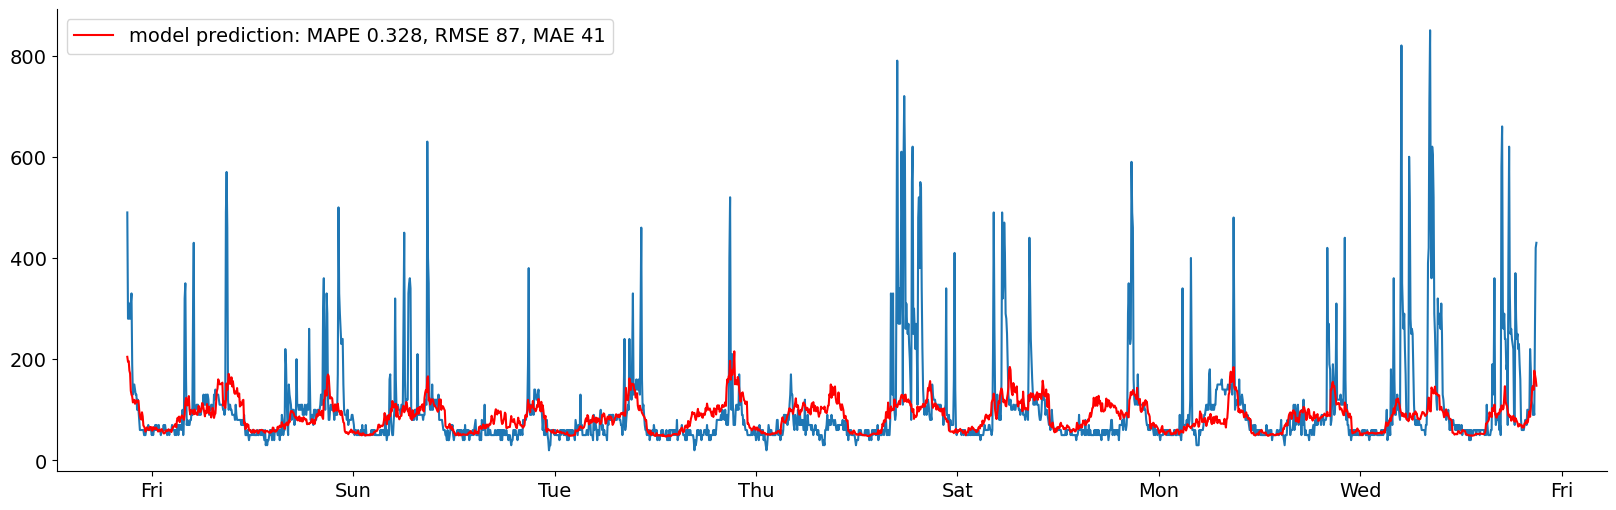

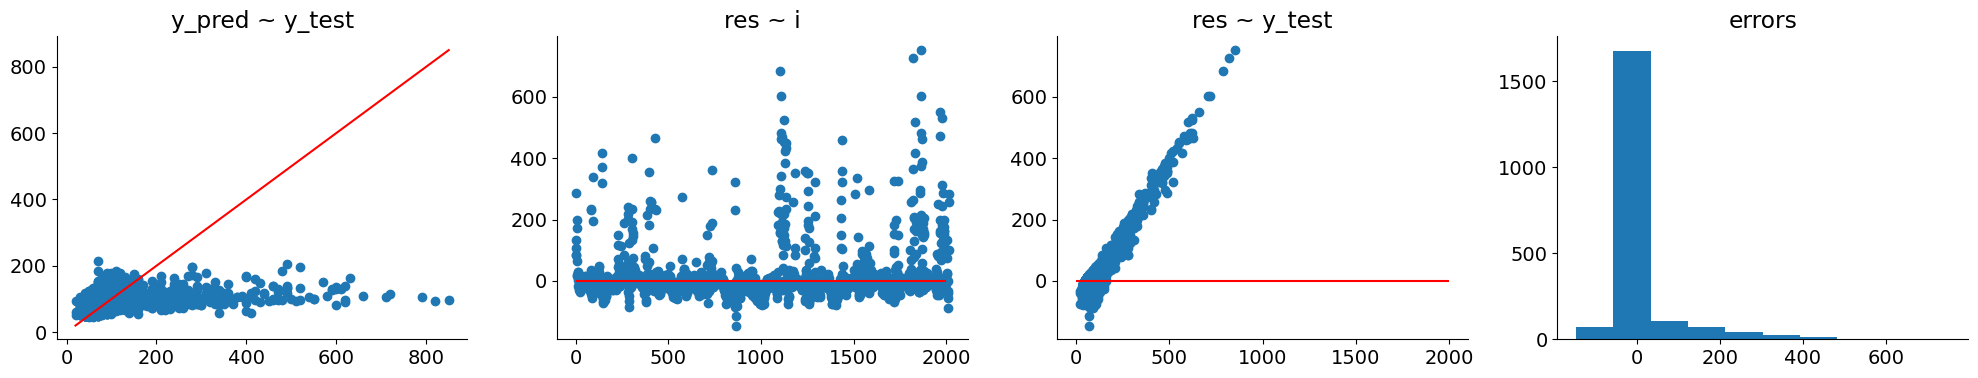

In [14]:
evaluate_model(X_train, X_test, y_train, y_test, loaded_model)